# Updating the Penn World Tables at OWID

This notebook is for analysing the PWT 9.1 (which OWID currently uses) to update it to the most recent version (10). The idea is to replicate the structure of the older dataset to the new one.

### Index
- [Transformations to get the OWID structure](#Transformations-to-get-the-OWID-structure)
- [Comparing the results to the OWID-modified PWT 9.1](#Comparing-the-results-to-the-OWID-modified-PWT-9.1)

### Appendix
- [The changes in PWT 10.0](#The-changes-in-PWT-10.0)
- [The variables of PWT](#The-variables-of-PWT)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)


### Data sources
- [PWT 10.0](https://www.rug.nl/ggdc/productivity/pwt/?lang=en)
- [PWT 9.1](https://www.rug.nl/ggdc/productivity/pwt/pwt-releases/pwt9.1)
- [PWT 9.1 in Grapher](https://owid.cloud/admin/datasets/4239) (Processed by Diana Beltekian)

### Documentation
1. [Diana Beltekian PWT 9.1 documentation for OWID](https://docs.google.com/document/d/1Kg9ZqxXXfDWA7WxfDysB0GjwlQ6kK5x6kNP-m7Sjl-I/edit?pli=1#)
2. [User Guide to PWT 10.0](https://www.rug.nl/ggdc/docs/pwt100-user-guide-to-data-files.pdf) (Recommended for new users)
3. [What's new in PWT 10.0?](https://www.rug.nl/ggdc/docs/pwt100-whatsnew.pdf) (Recommended for experienced users)
4. [The Next Generation of the Penn World Table](https://www.rug.nl/ggdc/productivity/pwt/related-research-papers/the_next_generation_of_the_penn_world_table.pdf) (Section I is recommended, because it explains what types of real GDP variables are available and when should be used)
5. [PWT 8.0 - A user guide](https://www.rug.nl/ggdc/docs/pwt_80_user_guide.pdf) (For *a broader understanding of the choices that were made in constructing PWT and some of the ‘health warnings’*)

## Transformations to get the OWID structure
Using as a reference the document [(1)](https://docs.google.com/document/d/1Kg9ZqxXXfDWA7WxfDysB0GjwlQ6kK5x6kNP-m7Sjl-I/edit?pli=1#), the following transformations to PWT 10.0 are done to match the OWID structure in Grapher.
The transformation of many variables consists in multiplying them by 1,000,000 to change their units from "million USD" to just "USD". It is the case for:

- **Expenditure-side real GDP at chained PPPs**, `rgdpe`
- **Output-side real GDP at chained PPPs**, `rgdpo`
- **Real consumption of households and government at current PPPs**, `ccon`
- **Real domestic absorption at current PPPs**, `cda`
- **Expenditure-side real GDP at current PPPs**, `cgdpe`
- **Output-side real GDP at current PPPs**, `cgdpo`
- **Capital stock at current PPPs**, `cn`
- **Real GDP at constant 2011 national prices**, `rgdpna`
- **Real consumption at constant 2011 national prices**, `rconna`
- **Real domestic absorption at constant 2011 national prices**, `rdana`
- **Capital stock at constant 2011 national prices**, `rnna`

Two variables are multiplied by 1,000,000 to express their units in "people" instead of "million people"

- **Population**, `pop`
- **Number of persons engaged**, `emp`

Two variables are renamed:
- `rgdpo` is renamed **Total output-side real GDP**, `tot_rgdp_o`
- `rgdpe` is renamed **Total expenditure-side real GDP**, `tot_rgdp_e`

The variable `Productivity` is estimated as the **total real output-side GDP per hour worked**; it is then `tot_rgdp_o` divided by the average hours worked per persons engaged (`avh`) and the total number of persons engaged (`emp`)

Two real GDP per capita measures are also calculated:
- **Output-side real GDP per capita** (`gdppc_o`), as the total output-side real GDP `tot_rgdp_o` divided by the population `pop`
- **Expenditure-side real GDP per capita** (`gdppc_e`) , as the total expenditure-side real GDP `tot_rgdp_e` divided by the population `pop`



In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.io as pio

#Loading PWT 9.1
pwt9_path = Path('data/pwt91.xlsx')
pwt9 = pd.read_excel(pwt9_path,sheet_name='Data')

#Loading PWT 10.0
pwt10_path = Path('data/pwt100.xlsx')
pwt10 = pd.read_excel(pwt10_path,sheet_name='Data')

#Multiplying by 1 million to get USD instead of millions of USD
pwt10['rgdpe'] = pwt10['rgdpe']*1000000
pwt10['rgdpo'] = pwt10['rgdpo']*1000000
pwt10['ccon'] = pwt10['ccon']*1000000
pwt10['cda'] = pwt10['cda']*1000000
pwt10['cgdpe'] = pwt10['cgdpe']*1000000
pwt10['cgdpo'] = pwt10['cgdpo']*1000000
pwt10['cn'] = pwt10['cn']*1000000
pwt10['rgdpna'] = pwt10['rgdpna']*1000000
pwt10['rconna'] = pwt10['rconna']*1000000
pwt10['rdana'] = pwt10['rdana']*1000000
pwt10['rnna'] = pwt10['rnna']*1000000

#Multiplying by 1 million to get "people" instead of "millions of people"
pwt10['pop'] = pwt10['pop']*1000000
pwt10['emp'] = pwt10['emp']*1000000

#New variables which are a direct transformation of others:

pwt10['tot_rgdp_o'] = pwt10['rgdpo']
pwt10['tot_rgdp_e'] = pwt10['rgdpe']

#Productivity = (tot_rgdp_o) / (avh*emp)
#Productivity is total real output-side GDP per hour worked; where hours worked are calculated by multiplying
#the average hours worked per persons engaged by the total number of persons engaged.
pwt10['Productivity'] = pwt10['tot_rgdp_o']/(pwt10['avh']*pwt10['emp'])

#Gdppc_o = tot_rgdpo / pop
#Output-side real GDP per capita is calculated by dividing total output-side GDP by the total population.
pwt10['gdppc_o'] = pwt10['tot_rgdp_o']/pwt10['pop']

#Gdppc_e = tot_rgdpe / pop
#Expenditure-side real GDP per capita is calculated by dividing total expenditure-side GDP by the total population.
pwt10['gdppc_e'] = pwt10['tot_rgdp_e']/pwt10['pop']

An interative calculation is necessary to create the `rgdpe_60`. This is the **real GDP per capita (expenditure-side) in 1960**. It is then `gdppc_e` value for each country in 1960.

In [2]:
for i in range(len(pwt10)): #runs for the entire length of th dataframe
    country = pwt10['countrycode'][i] #gets the country from row i
    #gets GDP_E from 1960 and the country I calculated in the previous row:
    gdp60_country = pwt10.loc[(pwt10['countrycode'] == country) & (pwt10['year'] == 1960), 'gdppc_e'].iloc[0]
    pwt10.loc[i,'rgdpe_60'] = gdp60_country #assigns the 1960 GDP value from "country" to every year for that country

The variable `gdppc_o_yearbefore` is the **GDP per capita (output-side) lagged by one year**. This variable will be useful for the estimation of `rgdpo_17_60`, the average growth between 1960 and 2019.

In [3]:
for i in range(len(pwt10)): #runs for the entire length of th dataframe
    country = pwt10['countrycode'][i] #gets the country from row i
    year = pwt10['year'][i] #gets the year from row i
    try:
        #gets the gdp from "country" the year before to "year"
        gdp_yearbefore = pwt10.loc[(pwt10['countrycode'] == country) & (pwt10['year'] == year-1), 'gdppc_o'].iloc[0]
    except: #in case of error (no row available, no year before)
        gdp_yearbefore = None
    pwt10.loc[i,'gdppc_o_yearbefore'] = gdp_yearbefore #assigns the gdp from the previous year to the following year's row

**The real GDP growth per capita 1960-2019** (`rgdpo_17_60`) is defined as the average of the yearly growth rate of GDP per capita over the period 1960-2019. This is the mean of the logarithm of the GDP per capita (output-side) minus the GDP per capita (output-side) lagged by one year. To estimate this a separate dataset by country is generated.

In [4]:
#rgdpo_17_60 = mean(logrgdppco[_n] - logrgdppco[_n-1]) where logrgdppco = log(tot_rgdp_o/pop)
#Real GDP growth per capita is calculated as the average of the yearly growth rate of GDP per capita over the period 1960-2017.

#Filters the data only between 1960 and 2019 (before it was until 2017)
pwt10_60 = pwt10[(pwt10['year']>=1960) & (pwt10['year']<=2019)].copy().reset_index(drop=True)
#Calculates the difference between log(gdppc_o) from current year and the one from previous year
pwt10_60['log_diff'] = np.log(pwt10_60['gdppc_o']) - np.log(pwt10_60['gdppc_o_yearbefore'])

country_list = list(pwt10_60['countrycode'].unique()) #gets list of countries
growth_db = pd.DataFrame(columns=pwt10_60.columns) #creates an empty dataframe to use it in the following interation

for i in country_list: #for each country
    db_percountry = pwt10_60[pwt10_60['countrycode']==i].copy().reset_index(drop=True) #dataframe with data from country i
    growth_db_aux = pd.DataFrame(columns=db_percountry.columns) #another empty dataset to temporarily poblate fill it with data
    
    growth_db_aux.loc[0,'countrycode'] = i #assigns country i
    growth_db_aux.loc[0,'rgdpo_17_60'] = db_percountry['log_diff'].mean() #assigns the average gdp from 1960 to 1960
    growth_db_aux.loc[0,'rgdpo_17_60_count'] = db_percountry['log_diff'].count() #counts how many times the log diff is
    
    growth_db = growth_db.append(growth_db_aux,ignore_index=True) #Each country row is appended to get the growth per country db

growth_db['year'] = 1960
growth_db

countrycode country currency_unit  year rgdpe rgdpo  pop  emp  avh   hc  \
0           ABW     NaN           NaN  1960   NaN   NaN  NaN  NaN  NaN  NaN   
1           AGO     NaN           NaN  1960   NaN   NaN  NaN  NaN  NaN  NaN   
2           AIA     NaN           NaN  1960   NaN   NaN  NaN  NaN  NaN  NaN   
3           ALB     NaN           NaN  1960   NaN   NaN  NaN  NaN  NaN  NaN   
4           ARE     NaN           NaN  1960   NaN   NaN  NaN  NaN  NaN  NaN   
..          ...     ...           ...   ...   ...   ...  ...  ...  ...  ...   
178         VNM     NaN           NaN  1960   NaN   NaN  NaN  NaN  NaN  NaN   
179         YEM     NaN           NaN  1960   NaN   NaN  NaN  NaN  NaN  NaN   
180         ZAF     NaN           NaN  1960   NaN   NaN  NaN  NaN  NaN  NaN   
181         ZMB     NaN           NaN  1960   NaN   NaN  NaN  NaN  NaN  NaN   
182         ZWE     NaN           NaN  1960   NaN   NaN  NaN  NaN  NaN  NaN   

     ... tot_rgdp_o tot_rgdp_e Productivity gdppc_o gdppc_e rgdpe_60  \
0    ...        NaN        NaN          NaN     NaN     NaN      NaN   
1    ...        NaN        NaN          NaN     NaN     NaN      NaN   
2    ...        NaN        NaN          NaN     NaN     NaN      NaN   
3    ...        NaN        NaN          NaN     NaN     NaN      NaN   
4    ...        NaN        NaN          NaN     NaN     NaN      NaN   
..   ...        ...        ...          ...     ...     ...      ...   
178  ...        NaN        NaN          NaN     NaN     NaN      NaN   
179  ...        NaN        NaN          NaN     NaN     NaN      NaN   
180  ...        NaN        NaN          NaN     NaN     NaN      NaN   
181  ...        NaN        NaN          NaN     NaN     NaN      NaN   
182  ...        NaN        NaN          NaN     NaN     NaN      NaN   

    gdppc_o_yearbefore log_diff rgdpo_17_60 rgdpo_17_60_count  
0                  NaN      NaN    0.029081              49.0  
1                  NaN      NaN    0.007981              49.0  
2                  NaN      NaN    0.008441              49.0  
3                  NaN      NaN    0.028415              49.0  
4                  NaN      NaN   -0.030916              49.0  
..                 ...      ...         ...               ...  
178                NaN      NaN    0.042770              49.0  
179                NaN      NaN    0.031258              30.0  
180                NaN      NaN    0.010587              60.0  
181                NaN      NaN    0.010069              60.0  
182                NaN      NaN    0.002624              60.0  

[183 rows x 62 columns]

To derive variables associated with imports and exports it is necessary to load the additional National Accounts data file from PWT 10.0:

In [5]:
#loads the PWT 10.0 National Accounts dataset
pwt10_na_path = Path('data/pwt100-na-data.xlsx')
pwt10_na = pd.read_excel(pwt10_na_path,sheet_name='Data')
pwt10_na

countrycode  year           v_c          v_i          v_g          v_x  \
0             ABW  1970    190.088493   104.832028    46.397118   329.084418   
1             ABW  1971    200.221731   110.420430    48.870444   346.627254   
2             ABW  1972    210.895206   116.306757    51.475666   365.105375   
3             ABW  1973    222.137686   122.506820    54.219742   384.568500   
4             ABW  1974    233.979260   129.037449    57.109995   405.068867   
...           ...   ...           ...          ...          ...          ...   
12583         ZWE  2015  17870.048580  2003.427020  3768.540612  3824.968960   
12584         ZWE  2016  17126.635457  2026.381291  3724.229586  4098.132104   
12585         ZWE  2017  17491.357666  2138.449666  4772.171591  4332.805617   
12586         ZWE  2018  18729.151593  2272.487586  6228.315843  4619.344609   
12587         ZWE  2019  17134.262993  2066.239632  4673.664748  4188.249529   

               v_m         v_gdp           q_c          q_i  ...          q_x  \
0       303.871063    353.746880    273.190291   119.433299  ...   445.736416   
1       320.069766    372.604474    298.019110   130.287976  ...   486.247090   
2       337.132239    392.467331    325.104522   142.129179  ...   530.439550   
3       355.104176    413.389041    354.651654   155.046523  ...   578.648462   
4       374.033561    435.426048    386.883976   169.137938  ...   631.238762   
...            ...           ...           ...          ...  ...          ...   
12583  7503.864558  19963.120615  19269.601831  2042.669710  ...  3416.694225   
12584  6426.700365  20548.678073  17249.390687  2052.255128  ...  4134.227086   
12585  6693.882240  22040.902301  17491.357666  2138.449666  ...  4332.805617   
12586  7537.739087  24311.560545  16321.578110  2239.042905  ...  3064.543950   
12587  6621.658063  21440.758840  16416.646473  2062.648454  ...  3720.226374   

               q_m         q_gdp        pop    xr   xr2       v_gfcf  \
0       391.184712    468.555156   0.059063  1.79  1.79   103.706505   
1       426.737440    511.139668   0.059440  1.79  1.79   109.234925   
2       465.521361    557.594507   0.059840  1.79  1.79   115.058025   
3       507.830218    608.271350   0.060243  1.79  1.79   121.191526   
4       553.984269    663.553971   0.060528  1.79  1.79   127.652126   
...            ...           ...        ...   ...   ...          ...   
12583  6702.906865  20892.749447  13.814629  1.00  1.00  1995.427020   
12584  6483.304601  21050.671851  14.030331  1.00  1.00  2015.381291   
12585  6693.882240  22040.902301  14.236595  1.00  1.00  2130.449666   
12586  5000.651537  23105.406901  14.438802  1.00  1.00  2262.487586   
12587  5861.369575  21233.867668  14.645468  1.00  1.00  2056.880007   

            q_gfcf       emp  avh  
0       111.510398       NaN  NaN  
1       121.644999       NaN  NaN  
2       132.700685       NaN  NaN  
3       144.761124       NaN  NaN  
4       157.917756       NaN  NaN  
...            ...       ...  ...  
12583  2033.663696  6.393752  NaN  
12584  2043.717050  6.504374  NaN  
12585  2130.449666  6.611773  NaN  
12586  2227.451318  6.714952  NaN  
12587  2053.657751  6.831017  NaN  

[12588 rows x 21 columns]

This dataset is now merged with the PWT 10.0 (only the variables needed are selected):

In [6]:
#merge between pwt10 and pwt10_na (only 'v_x','v_m','v_gdp','xr2')
merge_pwtna_10 = pd.merge(pwt10, pwt10_na[['countrycode','year','v_x','v_m','v_gdp','xr2']], 
                          on=['countrycode','year'], how='left',validate='one_to_one')

Now the variable `Ratio` can be generated. This is the **Ratio of exports and imports to GDP (%)** and it is defined as the sum of exports and imports divided by the GDP at current prices. Although it is not necessary to transform them to USD, the calculation is useful to get the world trade variable afterwards.

In [7]:
#Ratio = ((ex_usd + imp_usd) / gdp_usd )*100, where ex_usd = v_x / xr2 to convert export (and v_m for import) values into US$.
#The ratio of exports and imports to GDP is calculated by summing a country’s total imports and exports, then dividing by the country’s GDP - after all values have been converted to US$.

merge_pwtna_10['exp_usd'] = merge_pwtna_10['v_x']/merge_pwtna_10['xr2']
merge_pwtna_10['imp_usd'] = merge_pwtna_10['v_m']/merge_pwtna_10['xr2']
merge_pwtna_10['gdp_usd'] = merge_pwtna_10['v_gdp']/merge_pwtna_10['xr2']
merge_pwtna_10['Ratio'] = (merge_pwtna_10['exp_usd'] + merge_pwtna_10['imp_usd'])/merge_pwtna_10['gdp_usd']*100

Similarly to the `Ratio`, **the world trade (% of GDP)** is defined as the sum of all world exports and imports divided by the world GDP. To estimate this a separate dataset by year is generated.

In [8]:
#World trade (% of GDP) = [ (world imports + world exports) / (world GDP) ]*100
#World trade is constructed by summing countries’ total imports to arrive at the ‘world’ estimate of imports,
#and doing the same for total exports, and GDP in each year to arrive at a ‘world’ estimate for each of the respective variables.

year_list = list(merge_pwtna_10['year'].unique()) #gets the list of years
world_db = pd.DataFrame(columns=merge_pwtna_10.columns) #creates an empty dataframe to use in the following interation

for i in year_list: #for each year
    #creates a filtered dataset for year i
    db_peryear = merge_pwtna_10[merge_pwtna_10['year']==i].copy().reset_index(drop=True)
    world_db_aux = pd.DataFrame(columns=db_peryear.columns) #auxiliar dataset to fill it with data per year
    
    world_db_aux.loc[0,'year'] = i #assign year i to the auxiliar dataset 
    world_db_aux.loc[0,'world_imports'] = db_peryear['imp_usd'].sum() #assign the sum of imp_usd to the auxiliar dataset 
    world_db_aux.loc[0,'world_exports'] = db_peryear['exp_usd'].sum() #assign the sum of exp_usd to the auxiliar dataset 
    world_db_aux.loc[0,'world_gdp'] = db_peryear['gdp_usd'].sum() #assign the sum of gdp_usd to the auxiliar dataset 
    
    world_db = world_db.append(world_db_aux,ignore_index=True) #Each year row is appended to get the trade per year db afterwards

world_db['country'] = "World" #assigns the country "World"

#estimation of the world trade, according to the formula
world_db['world_trade'] = (world_db['world_imports'] + world_db['world_exports'])/world_db['world_gdp']*100
world_db

countrycode country currency_unit  year rgdpe rgdpo  pop  emp  avh   hc  \
0          NaN   World           NaN  1950   NaN   NaN  NaN  NaN  NaN  NaN   
1          NaN   World           NaN  1951   NaN   NaN  NaN  NaN  NaN  NaN   
2          NaN   World           NaN  1952   NaN   NaN  NaN  NaN  NaN  NaN   
3          NaN   World           NaN  1953   NaN   NaN  NaN  NaN  NaN  NaN   
4          NaN   World           NaN  1954   NaN   NaN  NaN  NaN  NaN  NaN   
..         ...     ...           ...   ...   ...   ...  ...  ...  ...  ...   
65         NaN   World           NaN  2015   NaN   NaN  NaN  NaN  NaN  NaN   
66         NaN   World           NaN  2016   NaN   NaN  NaN  NaN  NaN  NaN   
67         NaN   World           NaN  2017   NaN   NaN  NaN  NaN  NaN  NaN   
68         NaN   World           NaN  2018   NaN   NaN  NaN  NaN  NaN  NaN   
69         NaN   World           NaN  2019   NaN   NaN  NaN  NaN  NaN  NaN   

    ... v_gdp  xr2 exp_usd imp_usd gdp_usd Ratio world_imports world_exports  \
0   ...   NaN  NaN     NaN     NaN     NaN   NaN  5.908827e+04  5.999312e+04   
1   ...   NaN  NaN     NaN     NaN     NaN   NaN  8.197005e+04  7.966989e+04   
2   ...   NaN  NaN     NaN     NaN     NaN   NaN  8.167701e+04  8.132733e+04   
3   ...   NaN  NaN     NaN     NaN     NaN   NaN  8.194889e+04  8.046128e+04   
4   ...   NaN  NaN     NaN     NaN     NaN   NaN  8.676557e+04  8.528570e+04   
..  ...   ...  ...     ...     ...     ...   ...           ...           ...   
65  ...   NaN  NaN     NaN     NaN     NaN   NaN  2.083075e+07  2.113060e+07   
66  ...   NaN  NaN     NaN     NaN     NaN   NaN  2.027361e+07  2.078581e+07   
67  ...   NaN  NaN     NaN     NaN     NaN   NaN  2.235689e+07  2.286164e+07   
68  ...   NaN  NaN     NaN     NaN     NaN   NaN  2.442194e+07  2.507296e+07   
69  ...   NaN  NaN     NaN     NaN     NaN   NaN  2.395004e+07  2.459433e+07   

       world_gdp world_trade  
0   6.025618e+05   19.762519  
1   7.115964e+05   22.715116  
2   7.958497e+05   20.481800  
3   8.502138e+05   19.102274  
4   8.753175e+05   19.655869  
..           ...         ...  
65  7.464424e+07   56.215122  
66  7.581486e+07   54.157479  
67  8.063839e+07   56.075680  
68  8.573956e+07   57.727036  
69  8.707164e+07   55.752210  

[70 rows x 71 columns]

To have every variable in the same dataset, this code joins the main PWT 10.0 with the by country and by year datasets used to generate the real GDP growth per capita 1960-2019 and the world trade.

In [9]:
pwt10_owid = merge_pwtna_10.append([growth_db, world_db], ignore_index=True)
pwt10_owid

countrycode country   currency_unit  year rgdpe rgdpo  pop  emp  avh  \
0             ABW   Aruba  Aruban Guilder  1950   NaN   NaN  NaN  NaN  NaN   
1             ABW   Aruba  Aruban Guilder  1951   NaN   NaN  NaN  NaN  NaN   
2             ABW   Aruba  Aruban Guilder  1952   NaN   NaN  NaN  NaN  NaN   
3             ABW   Aruba  Aruban Guilder  1953   NaN   NaN  NaN  NaN  NaN   
4             ABW   Aruba  Aruban Guilder  1954   NaN   NaN  NaN  NaN  NaN   
...           ...     ...             ...   ...   ...   ...  ...  ...  ...   
13058         NaN   World             NaN  2015   NaN   NaN  NaN  NaN  NaN   
13059         NaN   World             NaN  2016   NaN   NaN  NaN  NaN  NaN   
13060         NaN   World             NaN  2017   NaN   NaN  NaN  NaN  NaN   
13061         NaN   World             NaN  2018   NaN   NaN  NaN  NaN  NaN   
13062         NaN   World             NaN  2019   NaN   NaN  NaN  NaN  NaN   

        hc  ... imp_usd gdp_usd Ratio log_diff rgdpo_17_60 rgdpo_17_60_count  \
0      NaN  ...     NaN     NaN   NaN      NaN         NaN               NaN   
1      NaN  ...     NaN     NaN   NaN      NaN         NaN               NaN   
2      NaN  ...     NaN     NaN   NaN      NaN         NaN               NaN   
3      NaN  ...     NaN     NaN   NaN      NaN         NaN               NaN   
4      NaN  ...     NaN     NaN   NaN      NaN         NaN               NaN   
...    ...  ...     ...     ...   ...      ...         ...               ...   
13058  NaN  ...     NaN     NaN   NaN      NaN         NaN               NaN   
13059  NaN  ...     NaN     NaN   NaN      NaN         NaN               NaN   
13060  NaN  ...     NaN     NaN   NaN      NaN         NaN               NaN   
13061  NaN  ...     NaN     NaN   NaN      NaN         NaN               NaN   
13062  NaN  ...     NaN     NaN   NaN      NaN         NaN               NaN   

      world_imports world_exports     world_gdp world_trade  
0               NaN           NaN           NaN         NaN  
1               NaN           NaN           NaN         NaN  
2               NaN           NaN           NaN         NaN  
3               NaN           NaN           NaN         NaN  
4               NaN           NaN           NaN         NaN  
...             ...           ...           ...         ...  
13058  2.083075e+07  2.113060e+07  7.464424e+07   56.215122  
13059  2.027361e+07  2.078581e+07  7.581486e+07   54.157479  
13060  2.235689e+07  2.286164e+07  8.063839e+07   56.075680  
13061  2.442194e+07  2.507296e+07  8.573956e+07   57.727036  
13062  2.395004e+07  2.459433e+07  8.707164e+07   55.752210  

[13063 rows x 74 columns]

## Comparing the results to the OWID-modified PWT 9.1
The original PWT 9.1 dataset processed by Diana Beltekian is here:

In [10]:
pwt9_path = Path('data/Penn World Tables version 9.1 (2019).csv')
pwt9_owid = pd.read_csv(pwt9_path)
pwt9_owid

Entity  Year  Population (PWT 9.1 (2019))  \
0      Afghanistan  1970                          NaN   
1      Afghanistan  1971                          NaN   
2      Afghanistan  1972                          NaN   
3      Afghanistan  1973                          NaN   
4      Afghanistan  1974                          NaN   
...            ...   ...                          ...   
11931     Zimbabwe  2013                   15054506.0   
11932     Zimbabwe  2014                   15411675.0   
11933     Zimbabwe  2015                   15777451.0   
11934     Zimbabwe  2016                   16150362.0   
11935     Zimbabwe  2017                   16529903.0   

       Number of persons engaged (emp) (PWT 9.1 (2019))  \
0                                                   NaN   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
11931                                         7914061.0   
11932                                         8222111.5   
11933                                         8530669.0   
11934                                         8839398.0   
11935                                         9181251.0   

       Average annual hours worked by persons engaged (avh) (PWT 9.1 (2019))  \
0                                                    NaN                       
1                                                    NaN                       
2                                                    NaN                       
3                                                    NaN                       
4                                                    NaN                       
...                                                  ...                       
11931                                                NaN                       
11932                                                NaN                       
11933                                                NaN                       
11934                                                NaN                       
11935                                                NaN                       

       Human capital index (hc) (PWT 9.1 (2019))  \
0                                            NaN   
1                                            NaN   
2                                            NaN   
3                                            NaN   
4                                            NaN   
...                                          ...   
11931                                   2.504635   
11932                                   2.550258   
11933                                   2.584653   
11934                                   2.616257   
11935                                   2.648248   

       Real consumption of households and government (ccon) (PWT 9.1 (2019))  \
0                                                    NaN                       
1                                                    NaN                       
2                                                    NaN                       
3                                                    NaN                       
4                                                    NaN                       
...                                                  ...                       
11931                                       3.032034e+10                       
11932                                       3.083923e+10                       
11933                                       3.377164e+10                       
11934                                       3.220806e+10                       
11935                                       3.270660e+10                       

       Real domestic absorption (cda) (PWT 9.1 (2019))  \
0            

One option to compare the results is to merge both PWT 9.1 and 10.0 modified files by country and year:

In [11]:
pwt910_owid = pd.merge(pwt10_owid, pwt9_owid, left_on=['country','year'], right_on=['Entity', 'Year'],
                       how='left')
pwt910_owid = pwt910_owid.apply(pd.to_numeric, errors='ignore')

Th `describe()` command provides descriptive statistics for each pair of created variables, the ones from 10.0 and the ones from 9.1.


**Productivity** statistics for PWT 9.1 and PWT 10.0 are shown here:

In [12]:
pwt910_owid[['Productivity',
            'Productivity (PWT 9.1 (2019))']].describe()

Productivity  Productivity (PWT 9.1 (2019))
count   3492.000000                    3094.000000
mean      23.704562                      20.940164
std       18.875527                      16.418406
min        0.767641                       0.581635
25%        8.694989                       7.718899
50%       19.038816                      16.887054
75%       34.591091                      30.407500
max      129.025422                     109.772140

**Output-side real GDP per capita (gdppc_o)** statistics for PWT 9.1 and PWT 10.0 are shown here:

In [13]:
pwt910_owid[['gdppc_o',
            'Output-side real GDP per capita (gdppc_o) (PWT 9.1 (2019))']].describe()

gdppc_o  \
count   10399.000000   
mean    14101.818868   
std     23746.747198   
min       214.553121   
25%      2582.729843   
50%      6688.895069   
75%     16700.608434   
max    444763.340174   

       Output-side real GDP per capita (gdppc_o) (PWT 9.1 (2019))  
count                                        8978.000000           
mean                                        13137.860038           
std                                         31777.525563           
min                                           131.300230           
25%                                          2355.917800           
50%                                          5924.177950           
75%                                         14767.335250           
max                                        792461.310000

**Expenditure-side real GDP per capita (gdppc_e)** statistics for PWT 9.1 and PWT 10.0 are shown here:

In [14]:
pwt910_owid[['gdppc_e',
            'Expenditure-side real GDP per capita (gdppc_e) (PWT 9.1 (2019))']].describe()

gdppc_e  \
count   10399.000000   
mean    13261.811888   
std     19073.187025   
min       244.600971   
25%      2484.828579   
50%      6450.842889   
75%     16564.711641   
max    283541.174514   

       Expenditure-side real GDP per capita (gdppc_e) (PWT 9.1 (2019))  
count                                        8978.000000                
mean                                        11722.442000                
std                                         16388.798408                
min                                           223.094570                
25%                                          2332.925175                
50%                                          5923.908700                
75%                                         15019.273500                
max                                        255408.940000

**Real GDP per capita in 1960 at chained PPPs** statistics for PWT 9.1 and PWT 10.0 are shown here:

In [15]:
pwt910_owid[['rgdpe_60',
            'Real GDP per capita in 1960 at chained PPPs in 2011 US$ (PWT 9.1 (2019))']].describe()

rgdpe_60  \
count   7770.000000   
mean    4675.059081   
std     4673.684249   
min      516.729531   
25%     1481.193938   
50%     2823.067669   
75%     6251.700804   
max    22529.517768   

       Real GDP per capita in 1960 at chained PPPs in 2011 US$ (PWT 9.1 (2019))  
count                                         101.000000                         
mean                                         4485.353738                         
std                                          4418.631874                         
min                                           424.821320                         
25%                                          1352.829300                         
50%                                          2681.599400                         
75%                                          5793.041500                         
max                                         20199.258000

**Average real GDP per capita growth 1960-2017 (2019), chained PPPs** statistics for PWT 9.1 and PWT 10.0 are shown here:

In [16]:
pwt910_owid[['rgdpo_17_60',
            'Average real GDP per capita growth 1960-2017, chained PPPs in 2011 US$ (PWT 9.1 (2019))']].describe()

rgdpo_17_60  \
count   183.000000   
mean      0.020018   
std       0.017703   
min      -0.058615   
25%       0.011938   
50%       0.020645   
75%       0.029575   
max       0.088587   

       Average real GDP per capita growth 1960-2017, chained PPPs in 2011 US$ (PWT 9.1 (2019))  
count                                         162.000000                                        
mean                                            0.019618                                        
std                                             0.018949                                        
min                                            -0.067871                                        
25%                                             0.011979                                        
50%                                             0.021056                                        
75%                                             0.030333                                        
max                                             0.098073

**Ratio of exports and imports to GDP (%)** statistics for PWT 9.1 and PWT 10.0 are shown here:

In [17]:
pwt910_owid[['Ratio',
            ' Ratio of exports and imports to GDP (%) (PWT 9.1 (2019))']].describe()

Ratio   Ratio of exports and imports to GDP (%) (PWT 9.1 (2019))
count  10399.000000                                        9046.000000        
mean      76.805711                                          75.593404        
std       51.389653                                          49.685039        
min        0.193331                                           3.272921        
25%       41.839919                                          41.074567        
50%       66.272038                                          65.601731        
75%       98.751762                                          98.957901        
max      442.620019                                         441.603820

**World trade (% of GDP)** statistics for PWT 9.1 and PWT 10.0 are shown here:

In [18]:
pwt910_owid[['world_trade',
            'World trade (% of GDP) (PWT 9.1) (PWT 9.1 (2019))']].describe()

world_trade  World trade (% of GDP) (PWT 9.1) (PWT 9.1 (2019))
count    70.000000                                          68.000000
mean     37.224564                                          36.406719
std      13.391173                                          13.036881
min      19.102274                                          18.674465
25%      22.759858                                          22.497763
50%      36.344930                                          35.973371
75%      46.893291                                          46.114951
max      61.278147                                          61.113140

Every variable shows consistency between v9.1 and 10.0 in aggregate statistics. But how about differences by country?

In [19]:
pwt910_owid['gdppc_o_vs'] = pwt910_owid['gdppc_o']/pwt910_owid['Output-side real GDP per capita (gdppc_o) (PWT 9.1 (2019))']

pwt910_owid['gdppc_e_vs'] = pwt910_owid['gdppc_e']/pwt910_owid['Expenditure-side real GDP per capita (gdppc_e) (PWT 9.1 (2019))']

pwt910_owid['rgdpe_60_vs'] = pwt910_owid['rgdpe_60']/pwt910_owid['Real GDP per capita in 1960 at chained PPPs in 2011 US$ (PWT 9.1 (2019))']

pwt910_owid['Productivity_vs'] = pwt910_owid['Productivity']/pwt910_owid['Productivity (PWT 9.1 (2019))']

pwt910_owid['rgdpo_17_60_vs'] = pwt910_owid['rgdpo_17_60']/pwt910_owid['Average real GDP per capita growth 1960-2017, chained PPPs in 2011 US$ (PWT 9.1 (2019))']

pwt910_owid['Ratio_vs'] = pwt910_owid['Ratio']/pwt910_owid[' Ratio of exports and imports to GDP (%) (PWT 9.1 (2019))']

pwt910_owid['world_trade_vs'] = pwt910_owid['world_trade']/pwt910_owid['World trade (% of GDP) (PWT 9.1) (PWT 9.1 (2019))']

pwt910_owid_0 = pwt910_owid.fillna(0)

It seems it's not possible to render Plotly with interactivity on GitHub: [link](https://github.com/plotly/plotly.py/issues/931), so it is necessary to switch renderers depending on use.

[About renderers in Plotly](https://plotly.com/python/renderers/)

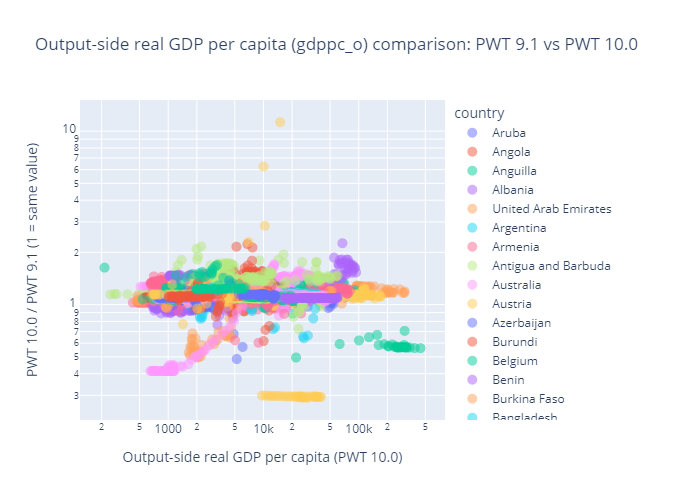

In [20]:
pio.renderers.default = "png" #"png" for GitHub, "notebook_connected" for local analysis

fig = px.scatter(pwt910_owid_0, x="gdppc_o", y="gdppc_o_vs", 
                 hover_data=['country', 'year'], opacity=0.5, color='country', 
                 title="Output-side real GDP per capita (gdppc_o) comparison: PWT 9.1 vs PWT 10.0",
                 log_x=True,
                 log_y=True,
                labels={
                     "gdppc_o": "Output-side real GDP per capita (PWT 10.0)",
                     "gdppc_o_vs": "PWT 10.0 / PWT 9.1 (1 = same value)",
                     "countrycode": "Country"
                 })

fig.update_traces(marker=dict(size=10, line=dict(width=0, color='blue')))
fig.show()

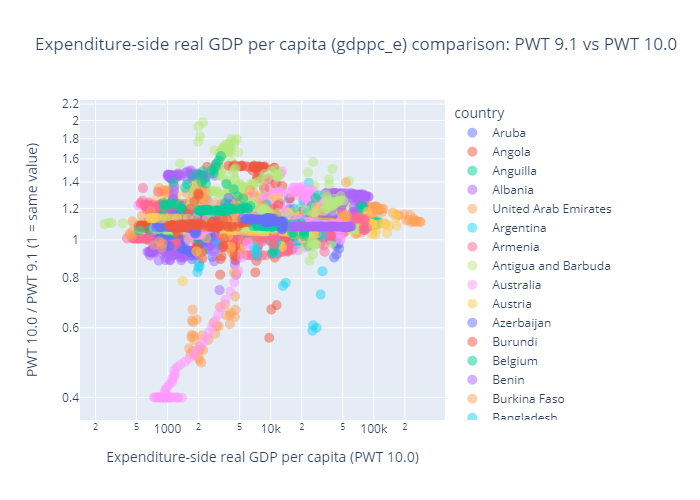

In [21]:
fig = px.scatter(pwt910_owid_0, x="gdppc_e", y="gdppc_e_vs", 
                 hover_data=['country', 'year'], opacity=0.5, color='country', 
                 title="Expenditure-side real GDP per capita (gdppc_e) comparison: PWT 9.1 vs PWT 10.0",
                 log_x=True,
                 log_y=True,
                labels={
                     "gdppc_e": "Expenditure-side real GDP per capita (PWT 10.0)",
                     "gdppc_e_vs": "PWT 10.0 / PWT 9.1 (1 = same value)",
                     "countrycode": "Country"
                 })

fig.update_traces(marker=dict(size=10, line=dict(width=0, color='blue')))
fig.show()

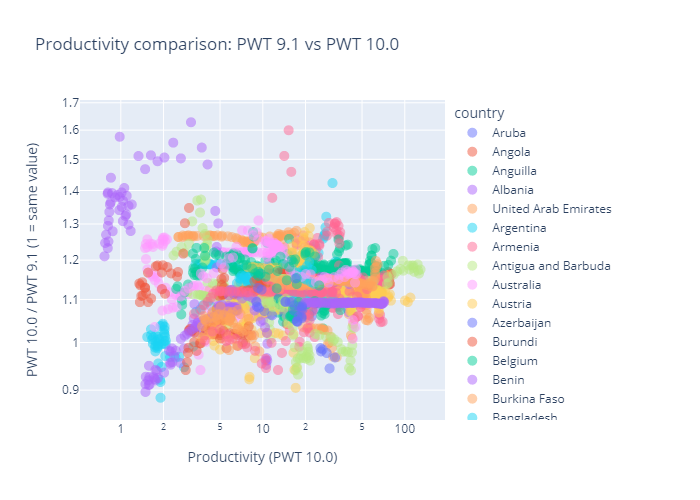

In [22]:
fig = px.scatter(pwt910_owid_0, x="Productivity", y="Productivity_vs", 
                 hover_data=['country', 'year'], opacity=0.5, color='country', 
                 title="Productivity comparison: PWT 9.1 vs PWT 10.0",
                 log_x=True,
                 log_y=True,
                 labels={
                     "Productivity": "Productivity (PWT 10.0)",
                     "Productivity_vs": "PWT 10.0 / PWT 9.1 (1 = same value)",
                     "countrycode": "Country"
                 })

fig.update_traces(marker=dict(size=10, line=dict(width=0, color='blue')))
fig.show()

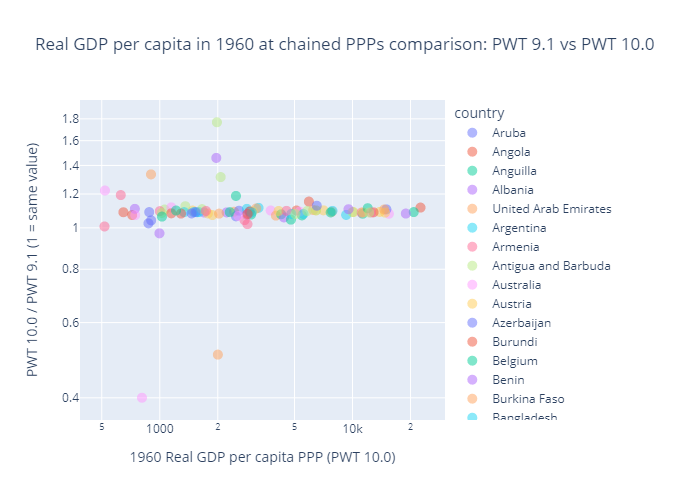

In [23]:
fig = px.scatter(pwt910_owid_0, x="rgdpe_60", y="rgdpe_60_vs", 
                 hover_data=['country'], opacity=0.5, color='country', 
                 title="Real GDP per capita in 1960 at chained PPPs comparison: PWT 9.1 vs PWT 10.0",
                 log_x=True,
                 log_y=True,
                labels={
                     "rgdpe_60": "1960 Real GDP per capita PPP (PWT 10.0)",
                     "rgdpe_60_vs": "PWT 10.0 / PWT 9.1 (1 = same value)",
                     "countrycode": "Country"
                 })

fig.update_traces(marker=dict(size=10, line=dict(width=0, color='blue')))
fig.show()

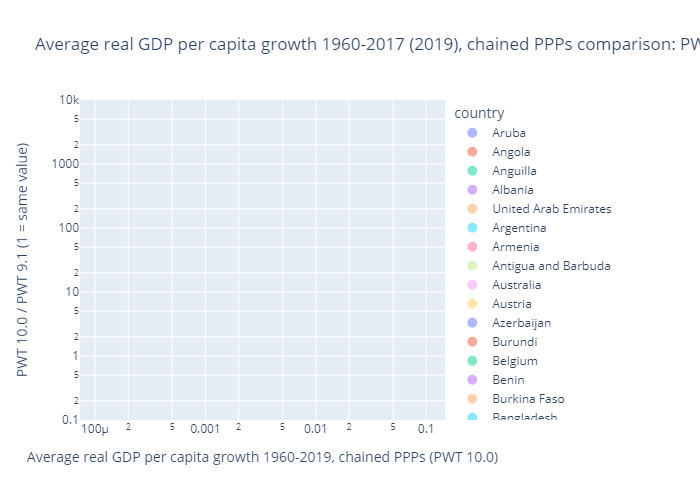

In [24]:
fig = px.scatter(pwt910_owid_0, x="rgdpo_17_60", y="rgdpo_17_60_vs", 
                 hover_data=['country'], opacity=0.5, color='country', 
                 title="Average real GDP per capita growth 1960-2017 (2019), chained PPPs comparison: PWT 9.1 vs PWT 10.0",
                 log_x=True,
                 log_y=True,
                labels={
                     "rgdpo_17_60": "Average real GDP per capita growth 1960-2019, chained PPPs (PWT 10.0)",
                     "rgdpo_17_60_vs": "PWT 10.0 / PWT 9.1 (1 = same value)",
                     "countrycode": "Country"
                 })

fig.update_traces(marker=dict(size=10, line=dict(width=0, color='blue')))
fig.show()

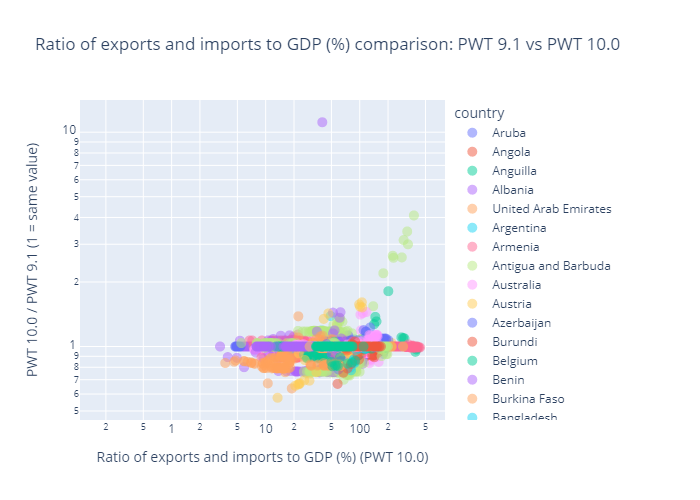

In [25]:
fig = px.scatter(pwt910_owid_0, x="Ratio", y="Ratio_vs", 
                 hover_data=['country', 'year'], opacity=0.5, color='country', 
                 title="Ratio of exports and imports to GDP (%) comparison: PWT 9.1 vs PWT 10.0",
                 log_x=True,
                 log_y=True,
                labels={
                     "Ratio": "Ratio of exports and imports to GDP (%) (PWT 10.0)",
                     "Ratio_vs": "PWT 10.0 / PWT 9.1 (1 = same value)",
                     "countrycode": "Country"
                 })

fig.update_traces(marker=dict(size=10, line=dict(width=0, color='blue')))
fig.show()

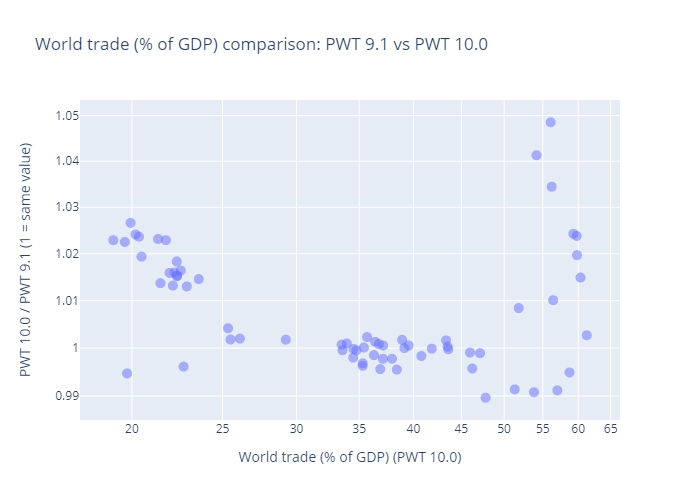

In [26]:
fig = px.scatter(pwt910_owid_0, x="world_trade", y="world_trade_vs", 
                 hover_data=['year'], opacity=0.5, 
                 title="World trade (% of GDP) comparison: PWT 9.1 vs PWT 10.0",
                 log_x=True,
                 log_y=True,
                labels={
                     "world_trade": "World trade (% of GDP) (PWT 10.0)",
                     "world_trade_vs": "PWT 10.0 / PWT 9.1 (1 = same value)",
                     "countrycode": "Country"
                 })

fig.update_traces(marker=dict(size=10, line=dict(width=0, color='blue')))
fig.show()

## Appendix

## The changes in PWT 10.0
According to [(2)](https://www.rug.nl/ggdc/docs/pwt100-user-guide-to-data-files.pdf), in its variables and their construction, version 10 **"closely resembles PWT versions 8.0, 8.1, 9.0
and 9.1"**. The changes from 9.1 to 10 include **"new relative price data, extended and revised
national accounts data, revisions to how we estimate employment data and a modification to the methodology for estimating investment by asset"**.

According to [(3)](https://www.rug.nl/ggdc/docs/pwt100-whatsnew.pdf), comparing with the 8.0 version (the last big change in the dataset) **"the main structure of the database and definition of its variables are unchanged in PWT 10.0"**. The changes fall in four broad categories:
1. *The incorporation of new purchasing power parities (PPPs) data for most countries for the years 2011 to 2017*
    
    PWT 10.0 adds revised ICP benchmarks for 2011, new benchmarks for 2017 and interpolated benchmarks for 2012-2016. Price levels for the expenditure categories are revised substantially. v9.1 interpolated the 2011 ICP benchmark for 2017 and for v10 they rely on direct ICP benchmark for nearly all countries, also replacing 2014 OECD and 2011-2017 Eurostat benchmarks. All of these changes lead to a higher dispersion in the differences. For years between the 2011 and 2017 ICP benchmarks, they rely on interpolations by the World Bank. Corrections to the GDP expenditure composition also result in additional adjustments clearer than household consumption in 2017.
    
    With the incorporation of the 2017 ICP data, the reference year has changed from 2011 in v9.0 and 9.1 to 2017 in v10.
    
    
2. *The incorporation of revised and extended National Accounts data, covering the period up to 2019*

    (1) mainly affects price levels, the new National Accounts data mainly affects nominal GDP levels and real growth rates. These revisions are commonly observed for African nations, but also in Latin America, the Caribban and Middle East (Paraguay, Niger and Djibouti are highlighted. It is mentioned in the document that these revisions are both welcome and alarming, because they reflect the effort made the national agencies, but also underscore the uncertainty about the true size of some economies.
    
    
3. *Revisions to how we estimate employment data, in particular for low and middle-income countries*
    
    v10.0 makes substantial changes to the source data for employment, modifies the link procedure used to combine the employment estimate from different sources. They incorporated more up-to-date information and evaluated the comparability of sources, which leads to the improved the estimates for a few dozen African, South/South-East Asian and Latin American countries. Revisions to the employment data in their original sources also alter the estimates for some countries, especially for more recent years. More details about the use of sources in pages 5 and 6.
    
    
4. *A modification to the methodology for estimating investment by asset*

    They adjusted the linking between National Account statistics dereived from the Total Economy Database and estimates using the Commodity-flow method (CFM). Argentina is shown as one of the more severe revisions, but in general the impact is for about 30 countries.
    
Other changes are:
- They replaced the exchange rate [xr] for Sudan for the years 1970 to 2019 with estimates from the World Bank’s World Development Indicators. This predominantly affects the Sudanese level of real GDP at current PPPs, and variables depending on these estimates (i.e. [ctfp]).
- They replaced the ICP benchmarks for the years 1996 and 2005 with benchmarks from Eurostat and the OECD whenever available. This resolved spikes in price levels for several European countries (notably GBR) and revised growth rates of price levels between 1985 and 1996 for several OECD countries.
- They updated PWT 10.0 due to an error in the current value of GDP [v_gdp] for their alternative time-series of China. Note that the variables relying on current GDP (e.g. [cgdpo], [rgdpo], etc.) as well as the reported price levels, were also affected by this revision for CHN.
- New TFP estimates: New employment and investment data has allowed them to extend TFP estimates for several countries: BWA, IDN, MUS, NAM, UZB, ZMB.
- New output/expenditure estimates: A new 2017 PPP benchmark for GUY allowed them to include this country in PWT 10.0.
- Update human capital [hc]: update from Barro and Lee v. 2.0 to 2.2. Revisions for CHN and DOM.
- Revision capital services [rkna]: fixed an issue in PWT 9.1, where the implied capital compensation ([k] / [ucc]) did not always equal (1-[labsh]) * [gdp]. This fix solves several breaks in [rkna], most notably for CZE, LVA, ROU and RUS.
- Revision price level capital stocks [pl_n]: fixed an issue in PWT 9.1, where the price level for capital stocks was always equal to the price level for GDP [pl_gdpo] for the USA. The price level for the USA is now estimated using asset-specific PPPs weighted by nominal capital stocks. It is set to 1 for the USA in the base year 2017.
- Outliers price levels. They have identified a number of new outliers in the price levels for GDP and Domestic Absorption (DA). They used the criteria discussed at length in the document “Outliers in PWT8.0”, available on the PWT website. In short, price levels for [cgdpo] and [cda] are marked an outlier if the price level is extrapolated from the first or last available benchmark and the observed level exceeds the bounds of a predicted level, based on an OLS regression of the log of GDP per capita and the log price level of GDP and DA respectively. New outliers were identified for one or more years for ABW, ALB, ARM, ATG, BGR, BLR, CYM, IRQ, OMN, SDN, SXM, TGO, TJK, VEN. Some of the outliers identified in PWT 9.0 and 9.1 were no longer identified as such. Consult the [i_outlier] variable for further details.

## The variables of PWT
In the documents [(2)](https://www.rug.nl/ggdc/docs/pwt100-user-guide-to-data-files.pdf) and [(3)](https://www.rug.nl/ggdc/docs/pwt100-whatsnew.pdf) is recommended to check the document [(4)](https://www.rug.nl/ggdc/productivity/pwt/related-research-papers/the_next_generation_of_the_penn_world_table.pdf) to see the variables that are published in the Penn World Tables. Although this paper refers to v8.1, there has not been major changes to the list. You can find below the list of key variables of PWT:

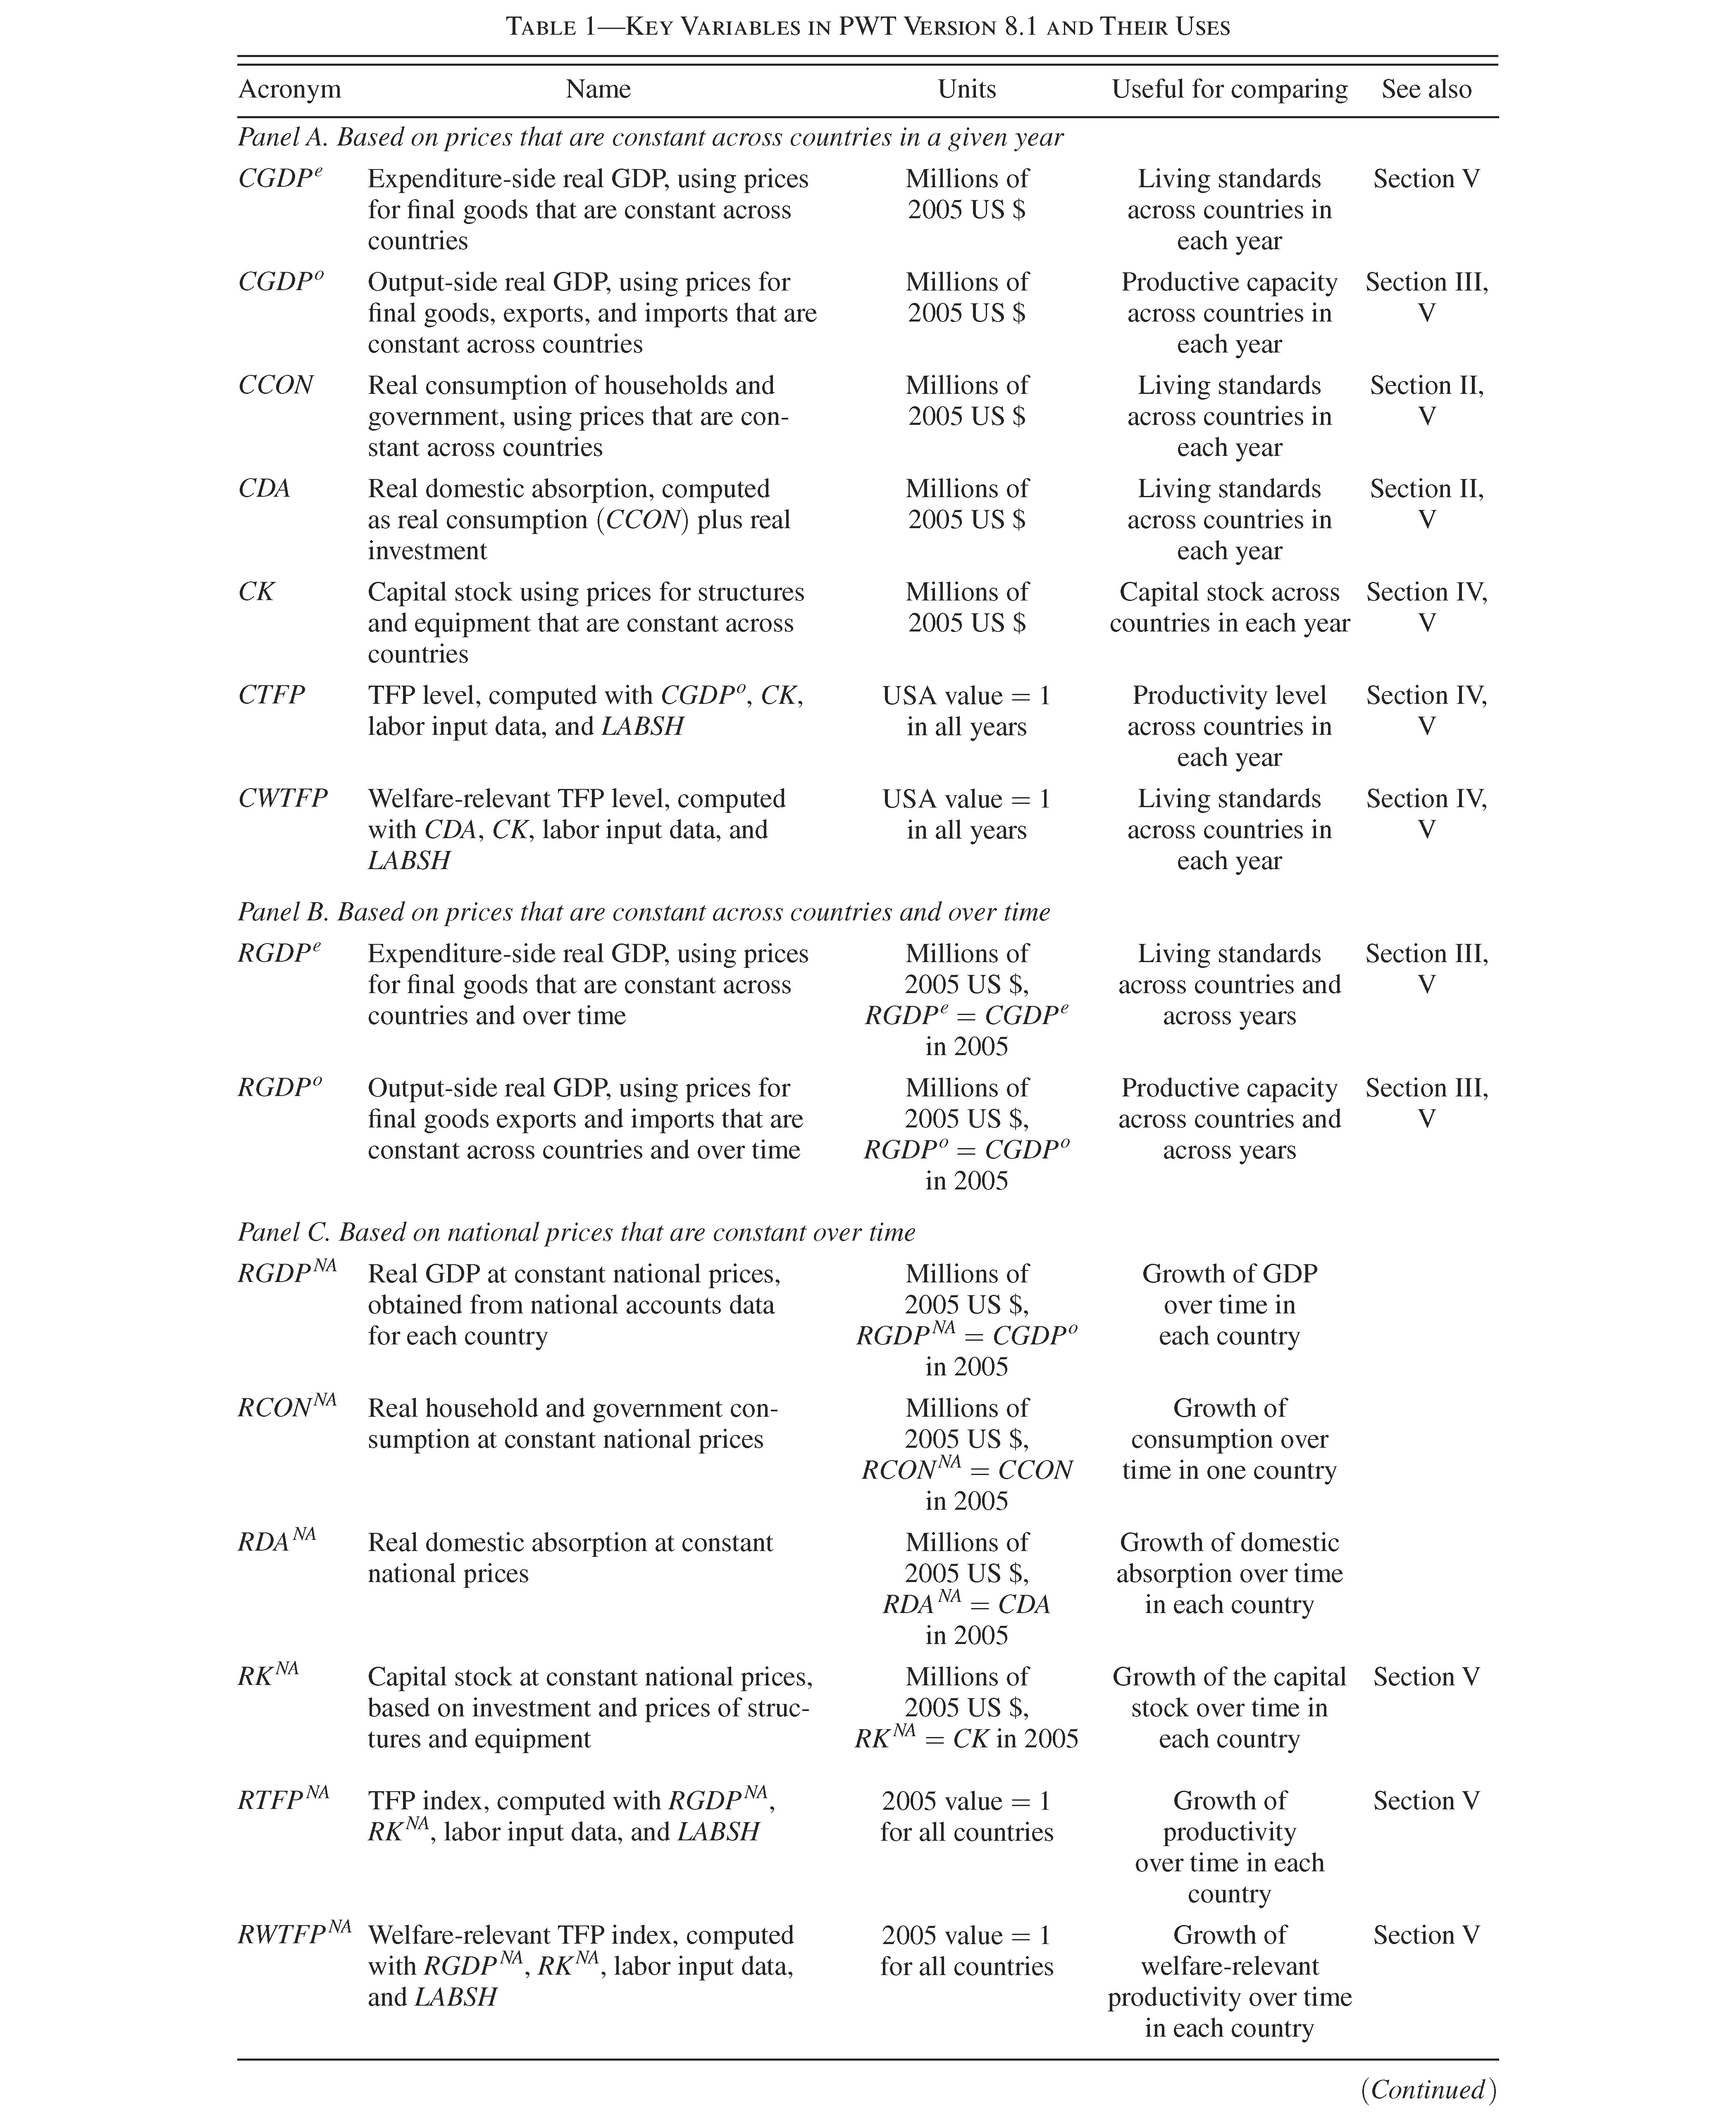

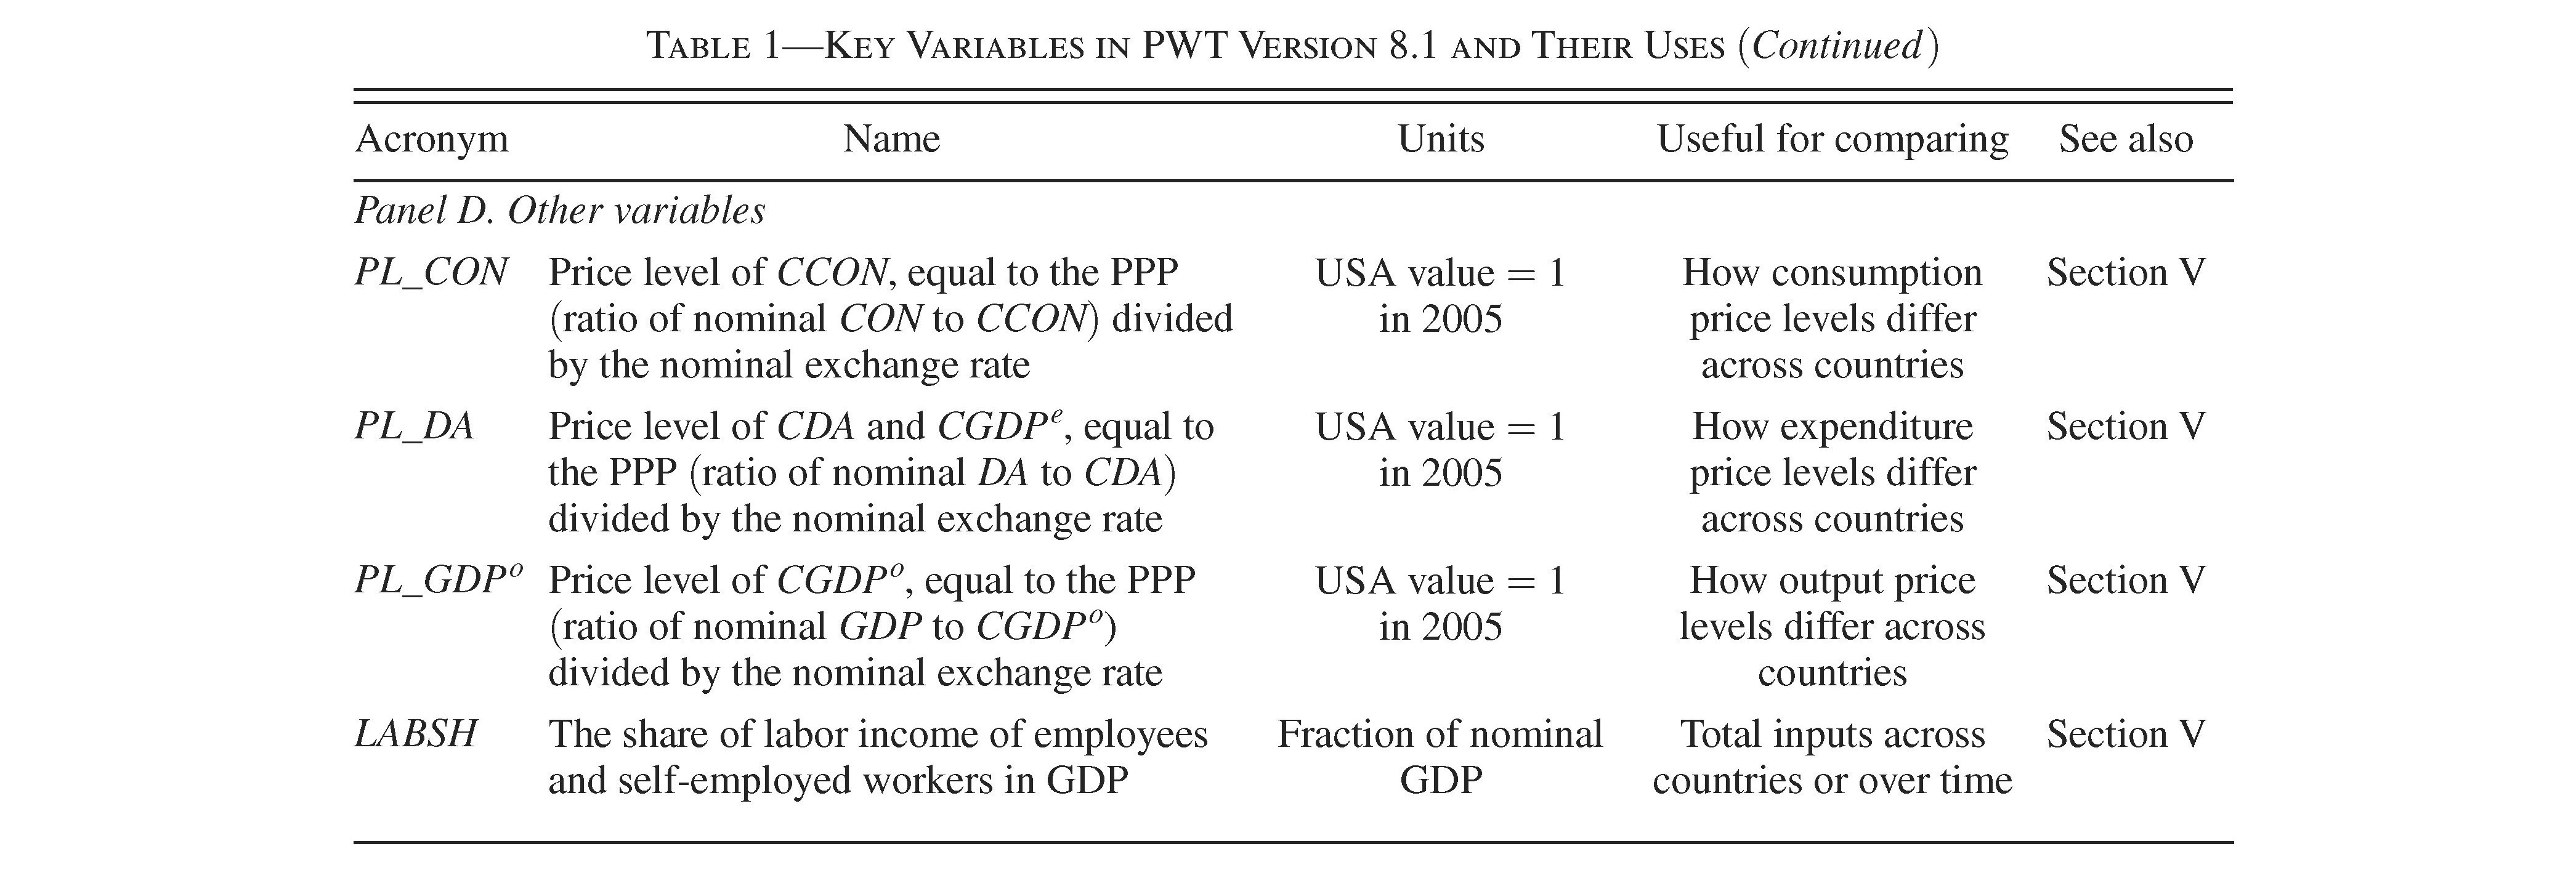

## Exploratory Data Analysis

Although in the documents it is stated that both versions 9.1 and 10 are virtually the same in terms of the list of variables, it is necessary to check this with the actual datasets

In [27]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import numpy as np
import plotly.express as px

#Loading PWT 9.1
pwt9_path = Path('data/pwt91.xlsx')
pwt9 = pd.read_excel(pwt9_path,sheet_name='Data')
pwt9

countrycode   country   currency_unit  year         rgdpe         rgdpo  \
0             ABW     Aruba  Aruban Guilder  1950           NaN           NaN   
1             ABW     Aruba  Aruban Guilder  1951           NaN           NaN   
2             ABW     Aruba  Aruban Guilder  1952           NaN           NaN   
3             ABW     Aruba  Aruban Guilder  1953           NaN           NaN   
4             ABW     Aruba  Aruban Guilder  1954           NaN           NaN   
...           ...       ...             ...   ...           ...           ...   
12371         ZWE  Zimbabwe       US Dollar  2013  28086.937500  28329.810547   
12372         ZWE  Zimbabwe       US Dollar  2014  29217.554688  29355.759766   
12373         ZWE  Zimbabwe       US Dollar  2015  30091.923828  29150.750000   
12374         ZWE  Zimbabwe       US Dollar  2016  30974.292969  29420.449219   
12375         ZWE  Zimbabwe       US Dollar  2017  32693.474609  30940.816406   

             pop       emp  avh        hc  ...     csh_x     csh_m     csh_r  \
0            NaN       NaN  NaN       NaN  ...       NaN       NaN       NaN   
1            NaN       NaN  NaN       NaN  ...       NaN       NaN       NaN   
2            NaN       NaN  NaN       NaN  ...       NaN       NaN       NaN   
3            NaN       NaN  NaN       NaN  ...       NaN       NaN       NaN   
4            NaN       NaN  NaN       NaN  ...       NaN       NaN       NaN   
...          ...       ...  ...       ...  ...       ...       ...       ...   
12371  15.054506  7.914061  NaN  2.504635  ...  0.169638 -0.426188  0.090225   
12372  15.411675  8.222112  NaN  2.550258  ...  0.141791 -0.340442  0.051500   
12373  15.777451  8.530669  NaN  2.584653  ...  0.137558 -0.354298 -0.023353   
12374  16.150362  8.839398  NaN  2.616257  ...  0.141248 -0.310446  0.003050   
12375  16.529903  9.181251  NaN  2.648248  ...  0.141799 -0.299539  0.019133   

           pl_c      pl_i      pl_g      pl_x      pl_m      pl_n      pl_k  
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
3           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
4           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
...         ...       ...       ...       ...       ...       ...       ...  
12371  0.577488  0.582022  0.448409  0.723247  0.632360  0.383488  0.704313  
12372  0.600760  0.557172  0.392895  0.724510  0.628352  0.349735  0.704991  
12373  0.622927  0.580814  0.343926  0.654940  0.564430  0.348472  0.713156  
12374  0.640176  0.599462  0.337853  0.657060  0.550084  0.346553  0.718671  
12375  0.647136  0.726222  0.340680  0.645338  0.539529  0.412392  0.755215  

[12376 rows x 52 columns]

In [28]:
#Loading PWT 10.0
pwt10_path = Path('data/pwt100.xlsx')
pwt10 = pd.read_excel(pwt10_path,sheet_name='Data')
pwt10

countrycode   country   currency_unit  year         rgdpe         rgdpo  \
0             ABW     Aruba  Aruban Guilder  1950           NaN           NaN   
1             ABW     Aruba  Aruban Guilder  1951           NaN           NaN   
2             ABW     Aruba  Aruban Guilder  1952           NaN           NaN   
3             ABW     Aruba  Aruban Guilder  1953           NaN           NaN   
4             ABW     Aruba  Aruban Guilder  1954           NaN           NaN   
...           ...       ...             ...   ...           ...           ...   
12805         ZWE  Zimbabwe       US Dollar  2015  40141.617188  39798.644531   
12806         ZWE  Zimbabwe       US Dollar  2016  41875.203125  40963.191406   
12807         ZWE  Zimbabwe       US Dollar  2017  44672.175781  44316.742188   
12808         ZWE  Zimbabwe       US Dollar  2018  44325.109375  43420.898438   
12809         ZWE  Zimbabwe       US Dollar  2019  42296.062500  40826.570312   

             pop       emp  avh        hc  ...     csh_x     csh_m     csh_r  \
0            NaN       NaN  NaN       NaN  ...       NaN       NaN       NaN   
1            NaN       NaN  NaN       NaN  ...       NaN       NaN       NaN   
2            NaN       NaN  NaN       NaN  ...       NaN       NaN       NaN   
3            NaN       NaN  NaN       NaN  ...       NaN       NaN       NaN   
4            NaN       NaN  NaN       NaN  ...       NaN       NaN       NaN   
...          ...       ...  ...       ...  ...       ...       ...       ...   
12805  13.814629  6.393752  NaN  2.584653  ...  0.140172 -0.287693 -0.051930   
12806  14.030331  6.504374  NaN  2.616257  ...  0.131920 -0.251232 -0.016258   
12807  14.236595  6.611773  NaN  2.648248  ...  0.126722 -0.202827 -0.039897   
12808  14.438802  6.714952  NaN  2.680630  ...  0.144485 -0.263658 -0.020791   
12809  14.645468  6.831017  NaN  2.713408  ...  0.213562 -0.270959 -0.089798   

           pl_c      pl_i      pl_g      pl_x      pl_m      pl_n      pl_k  
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
3           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
4           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
...         ...       ...       ...       ...       ...       ...       ...  
12805  0.479228  0.651287  0.541446  0.616689  0.533235  0.422764  1.533909  
12806  0.470640  0.651027  0.539631  0.619789  0.519718  0.416510  1.491724  
12807  0.473560  0.639560  0.519956  0.619739  0.552042  0.415592  1.514525  
12808  0.543757  0.655473  0.529867  0.641361  0.561526  0.425143  1.590120  
12809  0.494755  0.652439  0.500927  0.487763  0.430082  0.420675  1.384068  

[12810 rows x 52 columns]

They have the same number of columns and the number of rows in PWT 10.0 is larger than in PWT 9.1, which is a good sign to think they have the same variables with new data for countries and years in PWT 10.0.

This is obviously not enough, so I get a list of the variables from both datasets

In [29]:
list_pwt9 = list(pwt9)
list_pwt9

['countrycode',
 'country',
 'currency_unit',
 'year',
 'rgdpe',
 'rgdpo',
 'pop',
 'emp',
 'avh',
 'hc',
 'ccon',
 'cda',
 'cgdpe',
 'cgdpo',
 'cn',
 'ck',
 'ctfp',
 'cwtfp',
 'rgdpna',
 'rconna',
 'rdana',
 'rnna',
 'rkna',
 'rtfpna',
 'rwtfpna',
 'labsh',
 'irr',
 'delta',
 'xr',
 'pl_con',
 'pl_da',
 'pl_gdpo',
 'i_cig',
 'i_xm',
 'i_xr',
 'i_outlier',
 'i_irr',
 'cor_exp',
 'statcap',
 'csh_c',
 'csh_i',
 'csh_g',
 'csh_x',
 'csh_m',
 'csh_r',
 'pl_c',
 'pl_i',
 'pl_g',
 'pl_x',
 'pl_m',
 'pl_n',
 'pl_k']

In [30]:
list_pwt10 = list(pwt10)
list_pwt10

['countrycode',
 'country',
 'currency_unit',
 'year',
 'rgdpe',
 'rgdpo',
 'pop',
 'emp',
 'avh',
 'hc',
 'ccon',
 'cda',
 'cgdpe',
 'cgdpo',
 'cn',
 'ck',
 'ctfp',
 'cwtfp',
 'rgdpna',
 'rconna',
 'rdana',
 'rnna',
 'rkna',
 'rtfpna',
 'rwtfpna',
 'labsh',
 'irr',
 'delta',
 'xr',
 'pl_con',
 'pl_da',
 'pl_gdpo',
 'i_cig',
 'i_xm',
 'i_xr',
 'i_outlier',
 'i_irr',
 'cor_exp',
 'statcap',
 'csh_c',
 'csh_i',
 'csh_g',
 'csh_x',
 'csh_m',
 'csh_r',
 'pl_c',
 'pl_i',
 'pl_g',
 'pl_x',
 'pl_m',
 'pl_n',
 'pl_k']

These two lists can be compared by using the `==` operator: 

In [31]:
list_pwt9 == list_pwt10

True

The equality is true so it can be said that both datasets have the same variables and with the same order. If the result was false it would be necessary to order them first to confirm the equality:

In [32]:
list_pwt9_ordered = list_pwt9.sort()
list_pwt10_ordered = list_pwt10.sort()
list_pwt9_ordered == list_pwt10_ordered

True

A join of both dataset is generated for a quick comparison between their variables

In [33]:
pwt9['version'] = "9.1"
pwt10['version'] = "10.0"
pwt9_10 = pwt9.append(pwt10, ignore_index=True)

The `seaborn` library allows to plot pairwise relations in a dataset:

- [pairplot documentation](https://seaborn.pydata.org/generated/seaborn.pairplot.html)
- [PairGrid documentation](https://seaborn.pydata.org/generated/seaborn.PairGrid.html#seaborn.PairGrid)

For instance, this way the differences in real and constant GDP each year can be plotted:

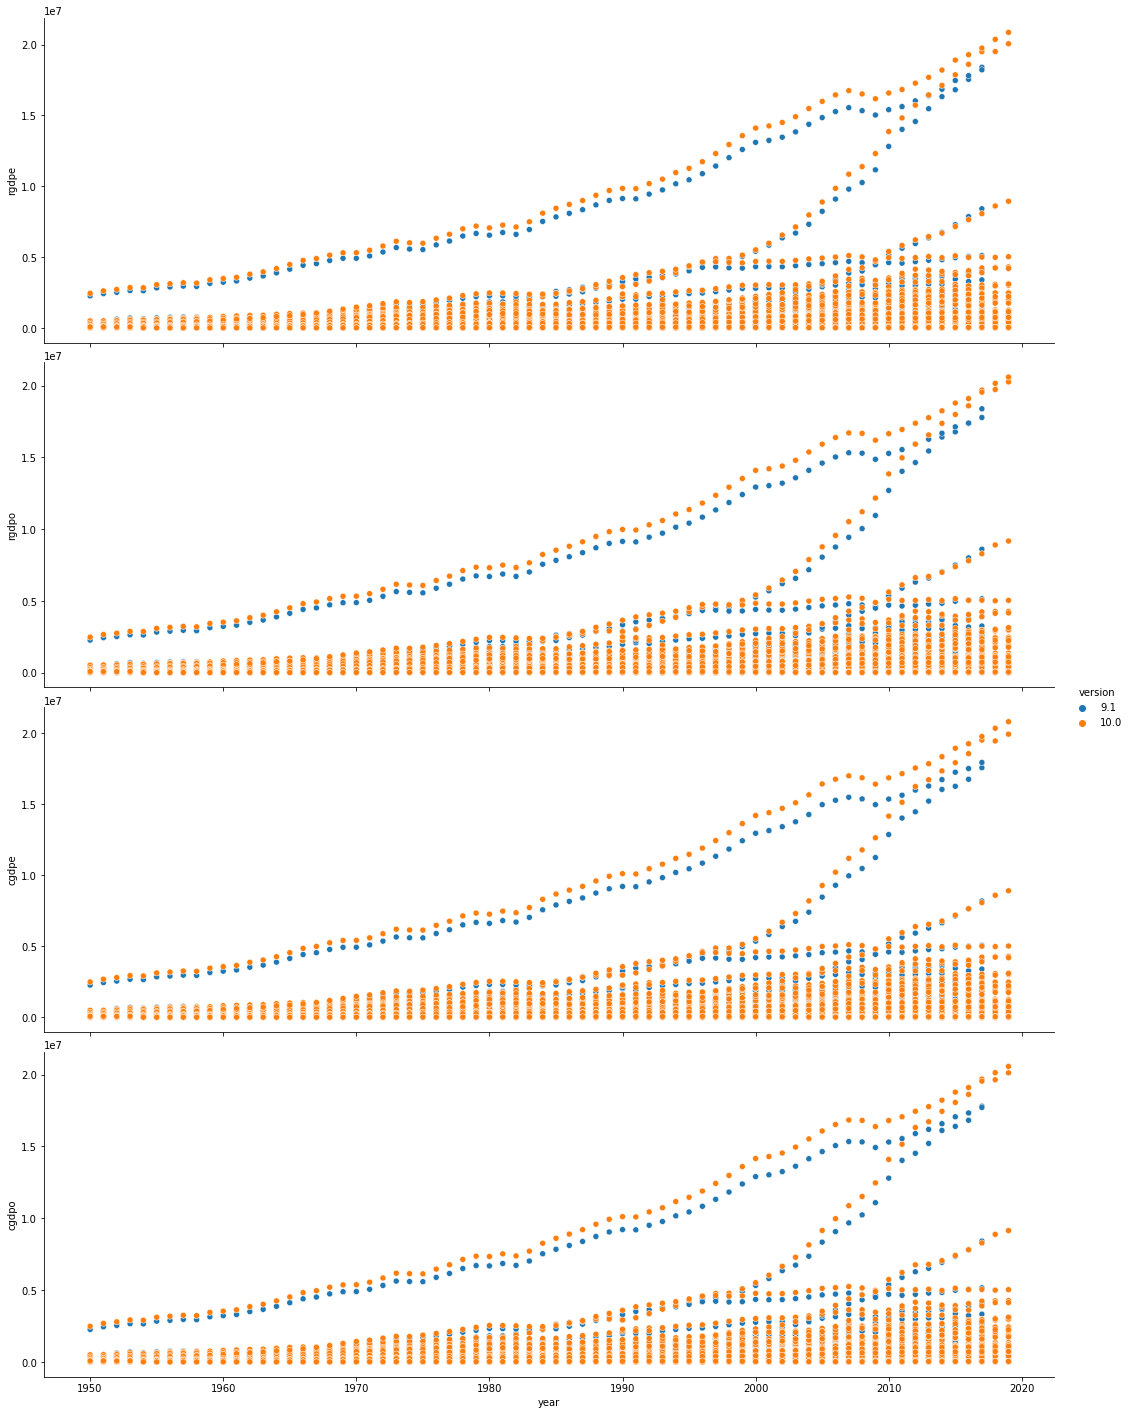

In [34]:
sns.pairplot(pwt9_10, x_vars='year',y_vars=['rgdpe','rgdpo', 'cgdpe', 'cgdpo'], 
             hue = "version", height=5, aspect=3, kind="scatter", dropna=True)

The rest of the variables can also be plotted against `year`:

In [35]:
#sns.pairplot(pwt9_10, x_vars='year', hue = "version", height=5, aspect=3)

It is clear that most variables change and not only for the most recent years, but for the entire time frame. The variables that don't change (much) are:
- pop
- emp
- hc
- xr (with outlier)
- statcap